In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import ee, eemont
from forestry_carbon_arr.core import ForestryCarbonARR
from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr

import gcsfs
import os

fs = gcsfs.GCSFileSystem(project=os.getenv("GOOGLE_CLOUD_PROJECT"), token='/usr/src/app/user_id.json')


forestry = ForestryCarbonARR(config_path='./00_input/korindo.json')
forestry.initialize_gee()

✓ GEE Initialized successfully
  Credentials Path: /usr/src/app/user_id.json - loaded successfully


In [3]:
# aoi
from forestry_carbon_arr.core.utils import DataUtils
import geopandas as gpd
import geemap

data_utils = DataUtils(forestry.config, use_gee=True)
aoi_gpd, aoi_ee = data_utils.load_geodataframe_gee(forestry.config["AOI_path"])

aoi_gpd_utm = aoi_gpd.to_crs(epsg=32749)

print(f"✅ AOI loaded: {len(aoi_gpd_utm)} features")
print(f"   Area: {aoi_gpd_utm.geometry.area.sum()/10000:.2f} hectares")

/opt/venv/lib/python3.12/site-packages/geemap/conversion.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


✅ AOI loaded: 1 features
   Area: 144217.67 hectares


In [4]:
use_yearly_ee = True
### load the exported gee image
asset_monthly_interpolated = 'projects/remote-sensing-476412/assets/korindo_smooth_monthly'

def annual_col_median(img_col, years):
    def per_year(year):
        start = ee.Date.fromYMD(year, 1, 1)
        end = start.advance(1, 'year')
        return (
            img_col
            .filterDate(start, end)
            .median()
            .set('year', year)
            .set('system:time_start', start.millis())
        )
    return ee.ImageCollection(years.map(per_year))

monthly_agg = ee.ImageCollection(asset_monthly_interpolated)

# Server-side list of unique years derived from system:time_start
year_list = (
    monthly_agg
        .aggregate_array('system:time_start')         # ee.List of millis
        .map(lambda ts: ee.Date(ts).get('year'))      # convert to year
        .distinct()                                   # keep unique values
        .sort()                                       # optional
)

ee_col_year_median = annual_col_median(monthly_agg, year_list)

year_list_c = year_list.getInfo()
print(year_list_c)

[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]


In [5]:
## check fcd data from random points
### wait until all the fcd is processed (exported)!
# ============================================
# STEP 2: Load directly from GCS when needed
# ============================================
# Later, when you need to use the images:
def load_yearly_images_from_gcs(years, gcs_bucket='remote_sensing_saas', base_path='01-korindo/yearly_mosaic_gee'):
    """
    Load yearly images directly from GCS without ingesting to GEE.
    
    Parameters:
    -----------
    years : list[int]
        List of years to load (e.g., [2020, 2021, 2022])
    gcs_bucket : str
        GCS bucket name
    base_path : str
        Base path in bucket
    
    Returns:
    --------
    ee.ImageCollection : Collection of images loaded from GCS
    """
    images = []
    for year in years:
        gcs_path = f'gs://{gcs_bucket}/{base_path}/fcd_{year}.tif'
        img = ee.Image.loadGeoTIFF(gcs_path)
        img = img.set('year', year)
        img = img.set('system:time_start', ee.Date.fromYMD(year, 12, 31).millis())
        images.append(img)
    
    return ee.ImageCollection(images)
fcd_col = load_yearly_images_from_gcs(year_list_c)
fcd_col.first().bandNames().getInfo()

['FCD']

In [6]:
fcd_col.first().projection().getInfo()


{'type': 'Projection',
 'crs': 'EPSG:32749',
 'transform': [10, 0, 578610, 0, -10, 9981520]}

In [7]:
forestry.config['resolution_satellite']

10

In [8]:
### convert the FCD image collection to the xee
# Now using UTM CRS with meter scale - they match!
import os

## path to the zarr file - GCS
gcs_dir = os.getenv('GCS_ZARR_DIR')

import xee
import numpy as np
import xarray as xr

print("🔄 Converting Earth Engine ImageCollection to xarray Dataset...")
print(f"   CRS: {'EPSG:32749'} (UTM, meters)")
print(f"   Scale: {10}m")
print("   This may take a moment as xee accesses the data from Earth Engine...")

# Reproject aoi_ee to UTM first (for region parameter)
# Use aoi_ee_utm already created in cell 11 (UTM geometry)

from shapely.geometry import box

utm_crs = forestry.config['output_crs']
utm_epsg = int(utm_crs.split(':')[1])
pixel_scale = forestry.config['resolution_satellite']

# bbox = box(*aoi_gpd_utm.total_bounds)
# Get UTM bounds from GeoDataFrame and validate
aoi_gpd_utm = aoi_gpd.to_crs(forestry.config['output_crs'])
bounds_utm = aoi_gpd_utm.total_bounds  # [minx, miny, maxx, maxy]

# Validate bounds are not NaN
if np.any(np.isnan(bounds_utm)):
    raise ValueError(f"Bounds contain NaN values: {bounds_utm}")

xmin, ymin, xmax, ymax = bounds_utm
print(f"UTM Bounds: xmin={xmin:.2f}, ymin={ymin:.2f}, xmax={xmax:.2f}, ymax={ymax:.2f}")
print(f"UTM Bounds span: {(xmax-xmin):.2f}m x {(ymax-ymin):.2f}m")

# Create rectangle geometry in UTM CRS
# rectangle = ee.Geometry.Rectangle(xmin, ymin, xmax, ymax)

## SETUP FOR FCD TO XARRAY
ic = fcd_col

# Method 2: Use transformed geometry directly (more reliable)
# Create UTM geometry from aoi_ee
aoi_ee_utm_geom = aoi_ee.geometry().transform(
    f'EPSG:{utm_epsg}',
    maxError=1
)

ds = xr.open_dataset(
    ic,
    engine='ee',
    crs=utm_crs,
    scale=pixel_scale,
    geometry=aoi_ee_utm_geom # significanly faster to clip with geometry
)
print("✅ Successfully created dataset using transformed geometry")

if 'X' in ds.dims and 'Y' in ds.dims:
    print("Renaming dimensions from X,Y to x,y")
    ds = ds.rename({'X': 'x', 'Y': 'y'})

print(f"\n📦 Dataset created: {type(ds)}")
print(f"   CRS: {utm_crs} (UTM, meters)")
print(f"   Scale: {pixel_scale}m")
print(f"   Dimensions: {dict(ds.dims)}")
print(f"   Data variables: {list(ds.data_vars.keys())}")
print(f"   Coordinates: {list(ds.coords.keys())}")

🔄 Converting Earth Engine ImageCollection to xarray Dataset...
   CRS: EPSG:32749 (UTM, meters)
   Scale: 10m
   This may take a moment as xee accesses the data from Earth Engine...
UTM Bounds: xmin=578614.54, ymin=9949385.44, xmax=623504.21, ymax=9981518.44
UTM Bounds span: 44889.68m x 32133.00m
✅ Successfully created dataset using transformed geometry
Renaming dimensions from X,Y to x,y

📦 Dataset created: <class 'xarray.core.dataset.Dataset'>
   CRS: EPSG:32749 (UTM, meters)
   Scale: 10m
   Dimensions: {'time': 11, 'x': 4489, 'y': 3213}
   Data variables: ['FCD']
   Coordinates: ['time', 'x', 'y']


/tmp/ipykernel_5052/2412302630.py:68: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"   Dimensions: {dict(ds.dims)}")


In [9]:
ds

<xarray.Dataset> Size: 635MB
Dimensions:  (time: 11, x: 4489, y: 3213)
Coordinates:
  * time     (time) datetime64[ns] 88B 2015-12-31 2016-12-31 ... 2025-12-31
  * x        (x) float64 36kB 5.786e+05 5.786e+05 ... 6.235e+05 6.235e+05
  * y        (y) float64 26kB 9.949e+06 9.949e+06 ... 9.982e+06 9.982e+06
Data variables:
    FCD      (time, x, y) float32 635MB ...
Attributes:
    crs:      EPSG:32749

In [10]:
from forestry_carbon_arr.utils.zarr_utils import save_dataset_efficient_zarr, load_dataset_zarr
import os

use_exported_ds = True

# Determine zarr path
zarr_path = os.getenv('GCS_ZARR_DIR', '')
if zarr_path:
    if not zarr_path.startswith('gs://'):
        zarr_path = f"gs://{zarr_path}/ds_resampled_fcd_merged.zarr"
    else:
        zarr_path = f"{zarr_path}/ds_resampled_fcd_merged.zarr"
    storage = 'gcs'
    # print(f"   Saving to GCS: {zarr_path}")
else:
    zarr_path = os.path.join(os.getcwd(), 'data', 'ds_resampled_fcd_merged.zarr')
    storage = 'local'
    print(f"   Saving to local: {zarr_path}")

if use_exported_ds != True:

    # Rename dimensions (X, Y -> x, y)
    # ds_resampled = ds.rename({'X': 'x', 'Y': 'y'}) # no need to do it twice from above
    ds_resampled = ds

    # Save to zarr
    chunk_sizes = {'time': 40, 'x': 1024, 'y': 1024}
    print("   Saving dataset to zarr...")
    save_dataset_efficient_zarr(
        ds_resampled,
        zarr_path,
        chunk_sizes=chunk_sizes,
        compression='lz4',
        compression_level=1,
        overwrite=True,
        storage=storage
    )
    print(f"✅ Dataset saved to zarr")

    # Load from zarr to avoid GEE server-side errors
    print(f"\n   Loading from: {zarr_path}")
else:
    ds_resampled = load_dataset_zarr(zarr_path, storage=storage)

print(f"✅ Dataset loaded from zarr")
print(f"   Dataset: {dict(ds_resampled.sizes)}")
print(f"   Variables: {list(ds_resampled.data_vars)}")
print(f"\n✅ ds_resampled ready for tsfresh processing")

📂 Loading dataset from GCS zarr: gs://remote_sensing_saas/01-korindo/timeseries_zarr/ds_resampled_fcd_merged.zarr
✅ Dataset loaded: {'time': 11, 'x': 4489, 'y': 3213}
✅ Dataset loaded from zarr
   Dataset: {'time': 11, 'x': 4489, 'y': 3213}
   Variables: ['FCD']

✅ ds_resampled ready for tsfresh processing


/usr/src/app/forestry_carbon_arr/utils/zarr_utils.py:833: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"✅ Dataset loaded: {dict(ds.dims)}")


In [23]:
gcs_path_df_long = f'gs://{os.getenv("GCS_BUCKET_PATH")}/01-korindo/sample_tsfresh/20251125_df_long_yearly.parquet'
training_gdf = gpd.read_parquet(gcs_path_df_long, filesystem=fs)

# # Check and set CRS if missing (parquet files sometimes lose CRS info)
# if training_gdf.crs is None:
#     print("⚠️  Training data has no CRS. Assuming EPSG:4326 (WGS84) and converting...")
#     training_gdf = training_gdf.set_crs('EPSG:4326', allow_override=True)
# else:
#     print(f"✓ Training data CRS: {training_gdf.crs}")

# # Convert to output CRS
# print(f"Converting to {forestry.config['output_crs']}...")
# training_gdf = training_gdf.to_crs(forestry.config['output_crs'])
# print(f"✓ Training data converted to {training_gdf.crs}")
training_gdf_yearly = training_gdf.copy()

# training_gdf

In [24]:
training_gdf_yearly

,layer,time_period,type,date,geometry,year
0,sample_2,t_201612,0,2016-12-31,"POLYGON ((592439.970 9950624.446, 592472.225 9...",2016
0,sample_2,t_201612,0,2016-12-31,"POLYGON ((590373.639 9951237.807, 590370.392 9...",2016
1,sample_2,t_201612,0,2016-12-31,"POLYGON ((591963.540 9951127.666, 591985.528 9...",2016
2,sample_2,t_201612,0,2016-12-31,"POLYGON ((592062.841 9950226.187, 592071.853 9...",2016
2,sample_2,t_201612,0,2016-12-31,"POLYGON ((591918.846 9950233.674, 591917.704 9...",2016
...,...,...,...,...,...,...
779,sample_1,t_202509,1,2025-12-31,"POLYGON ((589746.634 9954628.153, 589737.212 9...",2025
779,sample_1,t_202509,1,2025-12-31,"POLYGON ((589519.010 9954664.900, 589503.063 9...",2025
779,sample_1,t_202509,1,2025-12-31,"POLYGON ((590849.731 9953660.675, 590856.576 9...",2025
779,sample_1,t_202509,1,2025-12-31,"POLYGON ((591363.156 9954414.545, 591349.013 9...",2025


In [13]:
training_gdf_yearly.to_file('01_output/training_gdf_yearly_test.geojson', driver='GeoJSON')

In [21]:
training_gdf_yearly

,layer,time_period,type,date,geometry,year
0,sample_2,t_201612,0,2016-12-31,"POLYGON ((592439.970 9950624.446, 592472.225 9...",2016
0,sample_2,t_201612,0,2016-12-31,"POLYGON ((590373.639 9951237.807, 590370.392 9...",2016
1,sample_2,t_201612,0,2016-12-31,"POLYGON ((591963.540 9951127.666, 591985.528 9...",2016
2,sample_2,t_201612,0,2016-12-31,"POLYGON ((592062.841 9950226.187, 592071.853 9...",2016
2,sample_2,t_201612,0,2016-12-31,"POLYGON ((591918.846 9950233.674, 591917.704 9...",2016
...,...,...,...,...,...,...
779,sample_1,t_202509,1,2025-12-31,"POLYGON ((589746.634 9954628.153, 589737.212 9...",2025
779,sample_1,t_202509,1,2025-12-31,"POLYGON ((589519.010 9954664.900, 589503.063 9...",2025
779,sample_1,t_202509,1,2025-12-31,"POLYGON ((590849.731 9953660.675, 590856.576 9...",2025
779,sample_1,t_202509,1,2025-12-31,"POLYGON ((591363.156 9954414.545, 591349.013 9...",2025


In [ ]:
training_gdf_yearly[training_gdf_yearly['layer'] == 'gt_valid']

In [31]:
ground_truth_path = gcs_path_df_long

ds_gt_list = forestry.prepare_tsfresh_with_ground_truth(
    ds_resampled=ds_resampled,  # From Step 1
    ground_truth_path=ground_truth_path,  # GCS or local path to parquet
    buffer_pixels=5,  # Buffer around sample bboxes
    save_to_zarr=False,  # Save to zarr for efficient access
    zarr_path=None,  # Auto-detects from GCS_ZARR_DIR env var
    overwrite_zarr=False,  # Don't overwrite if exists
    storage='auto'
)

print(f"\n✅ Prepared {len(ds_gt_list)} sample datasets")
for i, ds_gt in enumerate(ds_gt_list):
    plot_id = ds_gt.coords['plot_id'].values[0] if 'plot_id' in ds_gt.coords else f'sample_{i+1}'
    print(f"   {plot_id}: {dict(ds_gt.sizes)}")
    print(f"      Variables: {list(ds_gt.data_vars)}")

  Converting sample_gdf CRS from {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "ProjectedCRS", "name": "WGS 84 / UTM zone 49S", "base_crs": {"name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "de


✅ Prepared 3 sample datasets
   sample_2: {'time': 11, 'x': 323, 'y': 212, 'plot_id': 1}
      Variables: ['FCD', 'ground_truth', 'gt_valid']
   sample_3: {'time': 11, 'x': 324, 'y': 251, 'plot_id': 1}
      Variables: ['FCD', 'ground_truth', 'gt_valid']
   sample_1: {'time': 11, 'x': 232, 'y': 141, 'plot_id': 1}
      Variables: ['FCD', 'ground_truth', 'gt_valid']


/usr/src/app/forestry_carbon_arr/utils/tsfresh_utils.py:407: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  logger.info(f"  ✓ Final dimensions: {dict(gt.dims)}")


In [32]:
ds_gt_list[2]

<xarray.Dataset> Size: 6MB
Dimensions:       (time: 11, x: 232, y: 141, plot_id: 1)
Coordinates:
  * time          (time) datetime64[ns] 88B 2015-12-31 2016-12-31 ... 2025-12-31
  * x             (x) float64 2kB 5.892e+05 5.892e+05 ... 5.915e+05 5.915e+05
  * y             (y) float64 1kB 9.955e+06 9.955e+06 ... 9.954e+06 9.954e+06
  * plot_id       (plot_id) object 8B 'sample_1'
    epsg          int64 8B 32749
Data variables:
    FCD           (plot_id, time, x, y) float32 1MB dask.array<chunksize=(1, 11, 128, 128), meta=np.ndarray>
    ground_truth  (plot_id, time, y, x) float32 1MB dask.array<chunksize=(1, 11, 128, 128), meta=np.ndarray>
    gt_valid      (plot_id, time, y, x) float64 3MB dask.array<chunksize=(1, 11, 128, 128), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [33]:
import pandas as pd

# Inspect first sample dataset
if len(ds_gt_list) > 0:
    ds_gt = ds_gt_list[0]
    plot_id = ds_gt.coords['plot_id'].values[0] if 'plot_id' in ds_gt.coords else 'sample_1'
    
    print(f"Sample: {plot_id}")
    print(f"Dimensions: {dict(ds_gt.sizes)}")
    print(f"Variables: {list(ds_gt.data_vars)}")
    print(f"\nTime range: {pd.to_datetime(ds_gt.time.min().values)} to {pd.to_datetime(ds_gt.time.max().values)}")
    
    # Check ground truth statistics
    if 'ground_truth' in ds_gt.data_vars:
        gt_values = ds_gt['ground_truth'].values.flatten()
        n_total = len(gt_values)
        n_nan = np.isnan(gt_values).sum()
        n_zeros = (gt_values == 0).sum()
        n_ones = (gt_values == 1).sum()
        
        print(f"\nGround Truth Statistics:")
        print(f"  Total pixels: {n_total:,}")
        print(f"  NaN (no label): {n_nan:,} ({100*n_nan/n_total:.1f}%)")
        print(f"  0 (non-tree): {n_zeros:,} ({100*n_zeros/n_total:.1f}%)")
        print(f"  1 (tree): {n_ones:,} ({100*n_ones/n_total:.1f}%)")
    
    # Show dataset structure
    print(f"\nDataset structure:")
    print(ds_gt)


Sample: sample_2
Dimensions: {'time': 11, 'x': 323, 'y': 212, 'plot_id': 1}
Variables: ['FCD', 'ground_truth', 'gt_valid']

Time range: 2015-12-31 00:00:00 to 2025-12-31 00:00:00

Ground Truth Statistics:
  Total pixels: 753,236
  NaN (no label): 250,436 (33.2%)
  0 (non-tree): 183,373 (24.3%)
  1 (tree): 319,427 (42.4%)

Dataset structure:
<xarray.Dataset> Size: 12MB
Dimensions:       (time: 11, x: 323, y: 212, plot_id: 1)
Coordinates:
  * time          (time) datetime64[ns] 88B 2015-12-31 2016-12-31 ... 2025-12-31
  * x             (x) float64 3kB 5.898e+05 5.898e+05 ... 5.93e+05 5.93e+05
  * y             (y) float64 2kB 9.952e+06 9.952e+06 ... 9.95e+06 9.95e+06
  * plot_id       (plot_id) object 8B 'sample_2'
    epsg          int64 8B 32749
Data variables:
    FCD           (plot_id, time, x, y) float32 3MB dask.array<chunksize=(1, 11, 128, 128), meta=np.ndarray>
    ground_truth  (plot_id, time, y, x) float32 3MB dask.array<chunksize=(1, 11, 128, 128), meta=np.ndarray>
    gt_val

VISUALIZING GROUND TRUTH: sample_3 at 2025-12-31
Found dataset with plot_id: sample_3


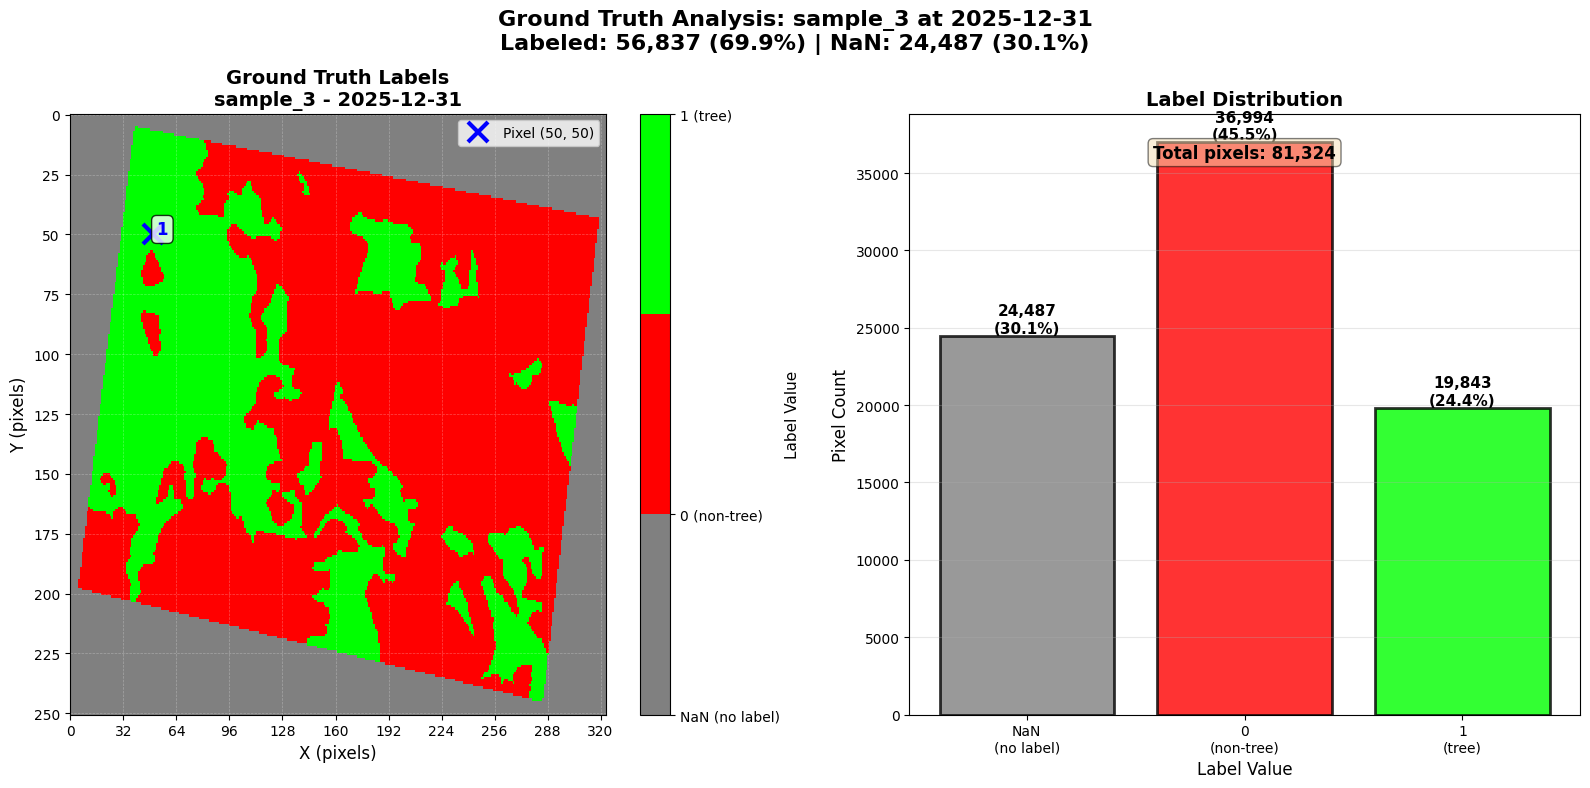


STATISTICS:
Total pixels: 81,324
  NaN (no label): 24,487 (30.11%)
  0 (non-tree):   36,994 (45.49%)
  1 (tree):       19,843 (24.40%)

Labeled pixels: 56,837 (69.89%)


In [43]:
# ============================================================================
# VISUALIZE: Ground Truth Labels Only (1, 0, NaN)
# ============================================================================
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

plot_name = 'sample_3'
time_str = '2025-12-31'

print("=" * 60)
print(f"VISUALIZING GROUND TRUTH: {plot_name} at {time_str}")
print("=" * 60)

# Find the dataset with matching plot_id
ds = None
for ds_candidate in ds_gt_list:
    if 'plot_id' in ds_candidate.coords:
        plot_id_value = ds_candidate.coords['plot_id'].values[0]
        if plot_id_value == plot_name:
            ds = ds_candidate
            break

if ds is None:
    raise ValueError(f"Could not find dataset with plot_id='{plot_name}'. Available plot_ids: {[ds.coords['plot_id'].values[0] if 'plot_id' in ds.coords else 'unknown' for ds in ds_gt_list]}")

print(f"Found dataset with plot_id: {ds.coords['plot_id'].values[0]}")


# Get ground truth slice
gt_slice = ds['ground_truth'].sel(plot_id=plot_name, time=time_str)

# Prepare data for visualization
gt_values = gt_slice.values.copy()
# Map: NaN -> -1, 0 -> 0, 1 -> 2 (for colormap indexing)
gt_plot = np.full_like(gt_values, -1, dtype=float)
gt_plot[gt_values == 0] = 0
gt_plot[gt_values == 1] = 2
gt_plot[np.isnan(gt_values)] = -1

# Count values
values = gt_values.flatten()
n_nan = np.isnan(values).sum()
n_zeros = (values == 0).sum()
n_ones = (values == 1).sum()
n_total = len(values)

# Create custom colormap: NaN=gray, 0=red, 1=green
colors = ['#808080', '#FF0000', '#00FF00']  # gray, red, green
cmap_custom = ListedColormap(colors)

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Ground Truth Labels
ax1 = axes[0]
im1 = ax1.imshow(gt_plot, cmap=cmap_custom, vmin=-1, vmax=2, aspect='auto', interpolation='nearest')
ax1.set_title(f'Ground Truth Labels\n{plot_name} - {time_str}', fontsize=14, fontweight='bold')
ax1.set_xlabel('X (pixels)', fontsize=12)
ax1.set_ylabel('Y (pixels)', fontsize=12)

# Add grid
ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.5, color='white')
ax1.set_xticks(range(0, gt_slice.shape[1], max(1, gt_slice.shape[1]//10)))
ax1.set_yticks(range(0, gt_slice.shape[0], max(1, gt_slice.shape[0]//10)))

# Add colorbar
cbar1 = plt.colorbar(im1, ax=ax1, ticks=[-1, 0, 2])
cbar1.set_ticklabels(['NaN (no label)', '0 (non-tree)', '1 (tree)'])
cbar1.set_label('Label Value', fontsize=11)

# Mark specific pixel if checking
check_x, check_y = 50, 50
if 0 <= check_x < gt_slice.shape[1] and 0 <= check_y < gt_slice.shape[0]:
    ax1.plot(check_x, check_y, 'bx', markersize=15, markeredgewidth=3, 
             label=f'Pixel ({check_x}, {check_y})')
    pixel_val = gt_values[check_y, check_x]
    if np.isnan(pixel_val):
        label_text = 'NaN'
    else:
        label_text = f'{int(pixel_val)}'
    ax1.text(check_x + 2, check_y, label_text, color='blue', 
             fontsize=12, fontweight='bold', bbox=dict(boxstyle='round', 
             facecolor='white', alpha=0.8))
    ax1.legend(loc='upper right', fontsize=10)

# Plot 2: Statistics Bar Chart
ax2 = axes[1]
categories = ['NaN\n(no label)', '0\n(non-tree)', '1\n(tree)']
counts = [n_nan, n_zeros, n_ones]
colors_bar = ['#808080', '#FF0000', '#00FF00']
percentages = [100 * c / n_total for c in counts]

bars = ax2.bar(categories, counts, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_title('Label Distribution', fontsize=14, fontweight='bold')
ax2.set_ylabel('Pixel Count', fontsize=12)
ax2.set_xlabel('Label Value', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for bar, pct, count in zip(bars, percentages, counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(count):,}\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add total count text
ax2.text(0.5, 0.95, f'Total pixels: {n_total:,}',
         transform=ax2.transAxes, ha='center', va='top',
         fontsize=12, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle(f'Ground Truth Analysis: {plot_name} at {time_str}\n'
             f'Labeled: {n_zeros + n_ones:,} ({100*(n_zeros+n_ones)/n_total:.1f}%) | '
             f'NaN: {n_nan:,} ({100*n_nan/n_total:.1f}%)',
             fontsize=16, fontweight='bold', y=0.98)

plt.tight_layout()
plt.show()

# Print statistics
print(f"\n" + "=" * 60)
print("STATISTICS:")
print("=" * 60)
print(f"Total pixels: {n_total:,}")
print(f"  NaN (no label): {n_nan:,} ({100*n_nan/n_total:.2f}%)")
print(f"  0 (non-tree):   {n_zeros:,} ({100*n_zeros/n_total:.2f}%)")
print(f"  1 (tree):       {n_ones:,} ({100*n_ones/n_total:.2f}%)")
print(f"\nLabeled pixels: {n_zeros + n_ones:,} ({100*(n_zeros+n_ones)/n_total:.2f}%)")


In [44]:
## check only gt_valid
# Quick random sampling
plot_name = 'sample_2'
time_str = '2025-12-31'
n_samples = 10

# Find the dataset with matching plot_id
ds = None
for ds_candidate in ds_gt_list:
    if 'plot_id' in ds_candidate.coords:
        plot_id_value = ds_candidate.coords['plot_id'].values[0]
        if plot_id_value == plot_name:
            ds = ds_candidate
            break

if ds is None:
    raise ValueError(f"Could not find dataset with plot_id='{plot_name}'. Available plot_ids: {[ds.coords['plot_id'].values[0] if 'plot_id' in ds.coords else 'unknown' for ds in ds_gt_list]}")

print(f"Found dataset with plot_id: {ds.coords['plot_id'].values[0]}")


# Get valid pixels
gt_slice = ds['ground_truth'].sel(plot_id=plot_name, time=time_str)
valid_mask = ~np.isnan(gt_slice.values)
y_indices, x_indices = np.where(valid_mask)

# Random sample
random_idx = np.random.choice(len(y_indices), size=min(n_samples, len(y_indices)), replace=False)
sampled_y = y_indices[random_idx]
sampled_x = x_indices[random_idx]
sampled_gt = gt_slice.values[sampled_y, sampled_x]

# Get coordinates
x_coords = gt_slice.x.values[sampled_x]
y_coords = gt_slice.y.values[sampled_y]

# Results
for i, (x, y, gt, xc, yc) in enumerate(zip(sampled_x, sampled_y, sampled_gt, x_coords, y_coords)):
    label = 'tree' if gt == 1 else 'non-tree'
    print(f"Pixel {i+1}: ({x}, {y}) at ({xc:.2f}, {yc:.2f}) → GT={int(gt)} ({label})")


Found dataset with plot_id: sample_2
Pixel 1: (177, 190) at (591549.54, 9950046.12) → GT=0 (non-tree)
Pixel 2: (178, 169) at (591559.54, 9950256.12) → GT=0 (non-tree)
Pixel 3: (89, 11) at (590669.54, 9951836.12) → GT=1 (tree)
Pixel 4: (219, 187) at (591969.54, 9950076.12) → GT=0 (non-tree)
Pixel 5: (268, 178) at (592459.54, 9950166.12) → GT=0 (non-tree)
Pixel 6: (106, 32) at (590839.54, 9951626.12) → GT=1 (tree)
Pixel 7: (113, 66) at (590909.54, 9951286.12) → GT=1 (tree)
Pixel 8: (269, 68) at (592469.54, 9951266.12) → GT=1 (tree)
Pixel 9: (260, 179) at (592379.54, 9950156.12) → GT=0 (non-tree)
Pixel 10: (117, 36) at (590949.54, 9951586.12) → GT=1 (tree)


Plot ID: sample_2
Plot ID: sample_3
Plot ID: sample_1
RANDOM PIXEL TIMESERIES PLOTS:
Bands: ['FCD']

Processing: sample_2
  Selected pixel: (y=48, x=291)
  Coordinates: (592689.54, 9951466.12)


    Ground truth markers: 0 trees (green), 0 non-trees (red)
  Timeseries: 11 time points, 0 labeled (0 tree, 0 non-tree)

Processing: sample_3
  Selected pixel: (y=2, x=212)
  Coordinates: (585379.54, 9970076.12)
    Ground truth markers: 0 trees (green), 0 non-trees (red)
  Timeseries: 11 time points, 0 labeled (0 tree, 0 non-tree)

Processing: sample_1
  Selected pixel: (y=23, x=54)
  Coordinates: (589769.54, 9954686.12)
    Ground truth markers: 10 trees (green), 0 non-trees (red)
  Timeseries: 11 time points, 10 labeled (10 tree, 0 non-tree)


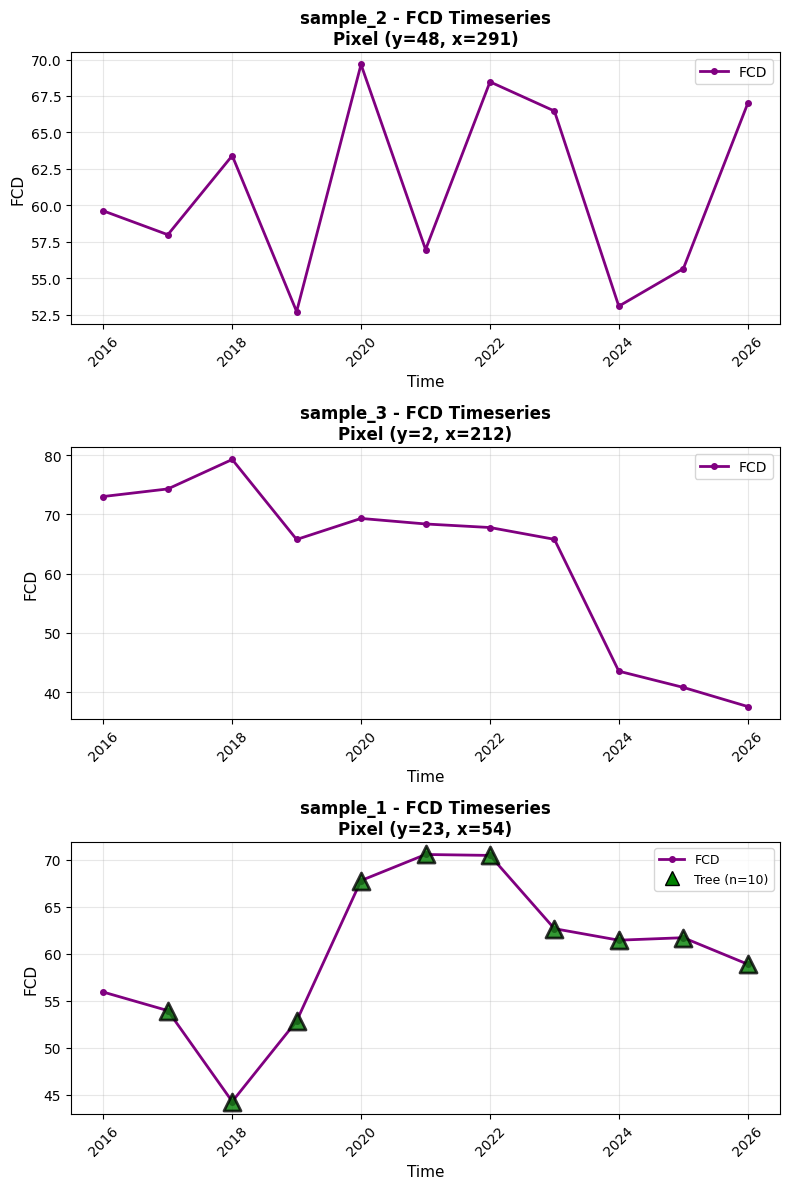


TIMESERIES PLOTS COMPLETE
Legend: Green triangle = tree (1), Red triangle = non-tree (0)


In [48]:
# ============================================================================
# MODULAR FUNCTION: Plot Random Pixel Timeseries for Specified Bands
# ============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_random_pixel_timeseries(ds_gt_list, band_list, figsize_per_plot=(8, 4), random_seed=None):
    """
    Plot timeseries for randomly selected valid pixels across multiple datasets and bands.
    
    Parameters
    ----------
    ds_gt_list : list of xarray.Dataset
        List of datasets, one per plot/sample
    band_list : list of str
        List of band names to plot (e.g., ['FCD'], ['NDVI', 'EVI'], ['FCD', 'NDVI', 'EVI'])
    figsize_per_plot : tuple, optional
        Figure size per subplot (width, height). Default (8, 4)
    random_seed : int, optional
        Random seed for reproducibility. Default None
    
    Returns
    -------
    None
        Displays matplotlib figure
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Validate bands exist in datasets
    available_bands = set()
    for ds in ds_gt_list:
        available_bands.update(ds.data_vars.keys())
    
    missing_bands = set(band_list) - available_bands
    if missing_bands:
        raise ValueError(f"Bands not found in datasets: {missing_bands}. Available bands: {sorted(available_bands)}")
    
    print("=" * 60)
    print("RANDOM PIXEL TIMESERIES PLOTS:")
    print(f"Bands: {band_list}")
    print("=" * 60)
    
    n_datasets = len(ds_gt_list)
    n_bands = len(band_list)
    
    # Create subplots: n_datasets rows, n_bands columns
    fig, axes = plt.subplots(n_datasets, n_bands, 
                             figsize=(figsize_per_plot[0] * n_bands, figsize_per_plot[1] * n_datasets))
    
    # Handle single dataset or single band case
    if n_datasets == 1:
        axes = axes.reshape(1, -1) if n_bands > 1 else axes.reshape(1, 1)
    elif n_bands == 1:
        axes = axes.reshape(-1, 1)
    
    # Color and marker styles for different bands
    band_styles = {
        'FCD': {'color': 'purple', 'marker': 'o', 'linestyle': '-'},
        'NDVI': {'color': 'green', 'marker': 'o', 'linestyle': '-'},
        'EVI': {'color': 'blue', 'marker': 's', 'linestyle': '-'},
    }
    # Default style for unknown bands
    default_style = {'color': 'black', 'marker': 'o', 'linestyle': '-'}
    
    for idx, ds in enumerate(ds_gt_list):
        plot_id = ds.plot_id.item() if hasattr(ds, 'plot_id') else ds.coords.get('plot_id', [f'plot_{idx}']).values[0]
        print(f"\nProcessing: {plot_id}")
        
        # Get gt_valid mask - aggregate over time: valid if valid at any time point
        if 'plot_id' in ds['gt_valid'].dims:
            valid_mask = ds['gt_valid'].isel(plot_id=0).any(dim='time').values
        else:
            valid_mask = ds['gt_valid'].any(dim='time').values if 'time' in ds['gt_valid'].dims else ds['gt_valid'].values
        
        # Find valid pixels
        if valid_mask.ndim == 2:
            valid_indices = np.where(valid_mask)
        else:
            print(f"  ⚠️  Unexpected valid_mask shape: {valid_mask.shape}")
            continue
        
        if len(valid_indices[0]) == 0:
            print(f"  ⚠️  No valid pixels found for {plot_id}")
            continue
        
        # Randomly select one valid pixel
        random_idx = np.random.choice(len(valid_indices[0]))
        y_idx = valid_indices[0][random_idx]
        x_idx = valid_indices[1][random_idx]
        
        print(f"  Selected pixel: (y={y_idx}, x={x_idx})")
        
        # Get coordinates
        x_coord = float(ds.x.isel(x=x_idx).values)
        y_coord = float(ds.y.isel(y=y_idx).values)
        print(f"  Coordinates: ({x_coord:.2f}, {y_coord:.2f})")
        
        # Extract ground truth timeseries
        if 'plot_id' in ds['ground_truth'].dims:
            gt_ts = ds['ground_truth'].isel(plot_id=0, y=y_idx, x=x_idx)
        else:
            gt_ts = ds['ground_truth'].isel(y=y_idx, x=x_idx)
        
        gt_values = np.atleast_1d(gt_ts.values).flatten()
        time_values = pd.to_datetime(gt_ts.time.values)
        
        # Plot each band
        for band_idx, band_name in enumerate(band_list):
            ax = axes[idx, band_idx]
            
            # Extract band timeseries
            if 'plot_id' in ds[band_name].dims:
                band_ts = ds[band_name].isel(plot_id=0, y=y_idx, x=x_idx)
            else:
                band_ts = ds[band_name].isel(y=y_idx, x=x_idx)
            
            band_values = np.atleast_1d(band_ts.values).flatten()
            
            # Get style for this band
            style = band_styles.get(band_name, default_style)
            
            # Plot timeseries
            ax.plot(time_values, band_values, 
                   color=style['color'], 
                   linewidth=2, 
                   label=band_name, 
                   marker=style['marker'], 
                   markersize=4,
                   linestyle=style['linestyle'])
            
            ax.set_title(f'{plot_id} - {band_name} Timeseries\nPixel (y={y_idx}, x={x_idx})', 
                        fontsize=12, fontweight='bold')
            ax.set_xlabel('Time', fontsize=11)
            ax.set_ylabel(band_name, fontsize=11)
            ax.grid(True, alpha=0.3)
            ax.legend()
            ax.tick_params(axis='x', rotation=45)
            
            # Add ground truth labels as colored markers
            tree_count = 0
            non_tree_count = 0
            for i, (t, gt_val) in enumerate(zip(time_values, gt_values)):
                gt_scalar = float(gt_val) if not isinstance(gt_val, (list, np.ndarray)) else float(gt_val[0])
                
                if not np.isnan(gt_scalar):
                    if gt_scalar == 1:
                        color = 'green'
                        marker = '^'
                        tree_count += 1
                    else:  # gt_scalar == 0
                        color = 'red'
                        marker = '^'  # Use same marker for visibility
                        non_tree_count += 1
                    
                    band_val = band_values[i]
                    ax.scatter(t, band_val, color=color, marker=marker, s=150, 
                             alpha=0.8, edgecolors='black', linewidth=2, zorder=5, label=None)
            
            # Add legend entry for ground truth markers if they exist
            if tree_count > 0 or non_tree_count > 0:
                from matplotlib.lines import Line2D
                # Get existing legend handles
                existing_handles, existing_labels = ax.get_legend_handles_labels()
                legend_elements = list(existing_handles)  # Start with existing handles
                
                if tree_count > 0:
                    legend_elements.append(Line2D([0], [0], marker='^', color='w', 
                                                 markerfacecolor='green', markersize=10, 
                                                 markeredgecolor='black', markeredgewidth=1,
                                                 label=f'Tree (n={tree_count})'))
                if non_tree_count > 0:
                    legend_elements.append(Line2D([0], [0], marker='^', color='w', 
                                                 markerfacecolor='red', markersize=10, 
                                                 markeredgecolor='black', markeredgewidth=1,
                                                 label=f'Non-tree (n={non_tree_count})'))
                
                if legend_elements:
                    ax.legend(handles=legend_elements, loc='best', fontsize=9)
            
            # Debug output for this band
            if band_idx == 0:  # Only print once per dataset
                print(f"    Ground truth markers: {tree_count} trees (green), {non_tree_count} non-trees (red)")
        
        # Print summary
        n_labeled = (~np.isnan(gt_values)).sum()
        n_trees = (gt_values == 1).sum()
        n_non_trees = (gt_values == 0).sum()
        print(f"  Timeseries: {len(time_values)} time points, {n_labeled} labeled ({n_trees} tree, {n_non_trees} non-tree)")
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 60)
    print("TIMESERIES PLOTS COMPLETE")
    print("=" * 60)
    print("Legend: Green triangle = tree (1), Red triangle = non-tree (0)")


# ============================================================================
# USAGE EXAMPLES
# ============================================================================
# Print available plot IDs
for ds in ds_gt_list:
    plot_id = ds.plot_id.item() if hasattr(ds, 'plot_id') else ds.coords.get('plot_id', ['unknown']).values[0]
    print(f"Plot ID: {plot_id}")

# Example 1: Plot only FCD
plot_random_pixel_timeseries(ds_gt_list, band_list=['FCD'], random_seed=42)

# Example 2: Plot multiple bands (uncomment to use)
# plot_random_pixel_timeseries(ds_gt_list, band_list=['FCD', 'NDVI', 'EVI'], random_seed=42)

RANDOM SAMPLING BY TYPE:
Bands: ['FCD']
Samples per type: 5 (tree) + 5 (non-tree) = 10 per plot

Processing: sample_2
  Found 31875 tree pixels, 18405 non-tree pixels
  Plotted 5 tree + 5 non-tree samples

Processing: sample_3
  Found 24641 tree pixels, 32196 non-tree pixels
  Plotted 5 tree + 5 non-tree samples

Processing: sample_1
  Found 20320 tree pixels, 5139 non-tree pixels
  Plotted 5 tree + 5 non-tree samples


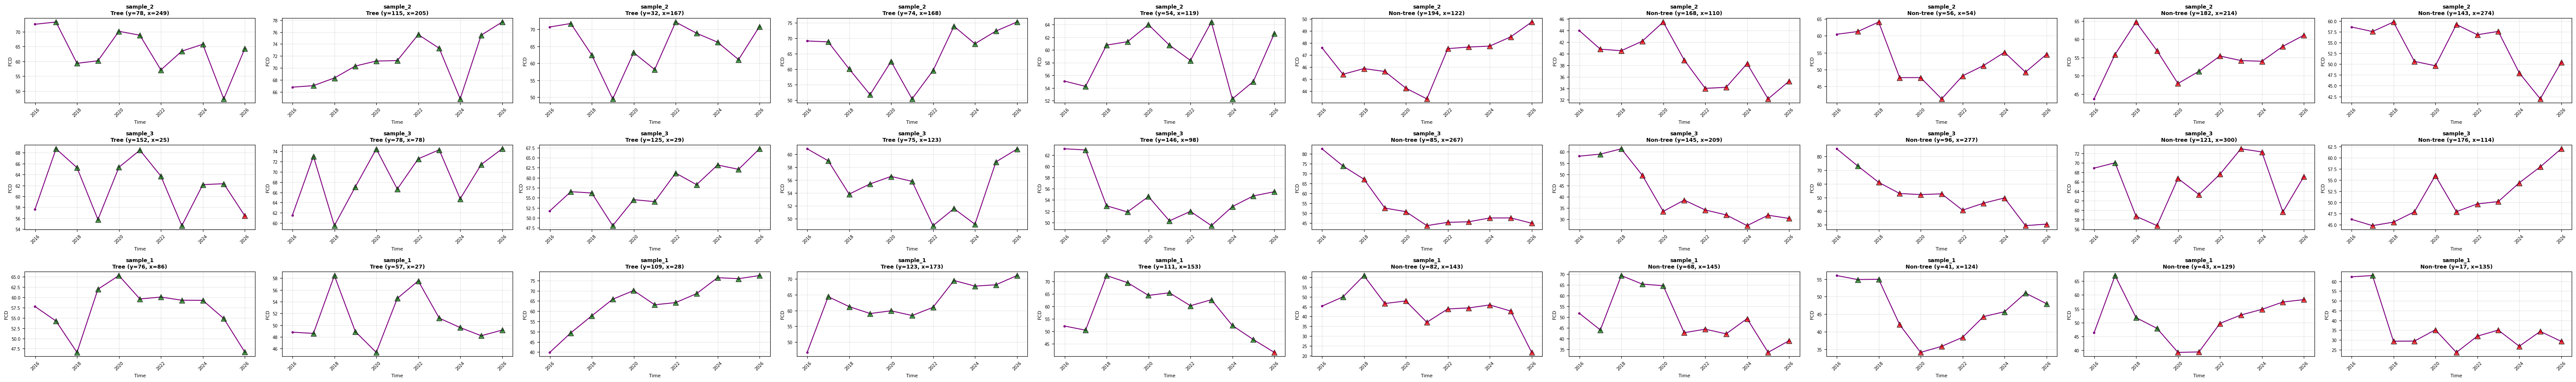


SAMPLING PLOTS COMPLETE
Layout: 3 plots (rows) × 10 samples (columns) = 5 tree + 5 non-tree per plot
Legend: Green triangle = tree (1), Red triangle = non-tree (0)


In [49]:
# ============================================================================
# RANDOM SAMPLING: 5 Tree + 5 Non-tree pixels per plot
# Creates 3 plots × 10 samples (5 tree + 5 non-tree) = 30 subplots
# ============================================================================
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D

def plot_random_samples_by_type(ds_gt_list, band_list, n_samples_per_type=5, figsize_per_plot=(6, 3), random_seed=None):
    """
    Plot timeseries for randomly selected pixels, ensuring representation of both tree and non-tree types.
    
    Parameters
    ----------
    ds_gt_list : list of xarray.Dataset
        List of datasets, one per plot/sample
    band_list : list of str
        List of band names to plot (e.g., ['FCD'])
    n_samples_per_type : int, optional
        Number of samples per type (tree/non-tree). Default 5
    figsize_per_plot : tuple, optional
        Figure size per subplot (width, height). Default (6, 3)
    random_seed : int, optional
        Random seed for reproducibility. Default None
    
    Returns
    -------
    None
        Displays matplotlib figure
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    # Validate bands exist in datasets
    available_bands = set()
    for ds in ds_gt_list:
        available_bands.update(ds.data_vars.keys())
    
    missing_bands = set(band_list) - available_bands
    if missing_bands:
        raise ValueError(f"Bands not found in datasets: {missing_bands}. Available bands: {sorted(available_bands)}")
    
    print("=" * 60)
    print("RANDOM SAMPLING BY TYPE:")
    print(f"Bands: {band_list}")
    print(f"Samples per type: {n_samples_per_type} (tree) + {n_samples_per_type} (non-tree) = {n_samples_per_type*2} per plot")
    print("=" * 60)
    
    n_datasets = len(ds_gt_list)
    n_bands = len(band_list)
    n_samples_total = n_samples_per_type * 2  # tree + non-tree
    
    # Create subplots: n_datasets rows × n_bands columns × n_samples_total sub-subplots
    # Actually, we want: n_datasets rows, (n_bands * n_samples_total) columns
    n_cols = n_bands * n_samples_total
    fig, axes = plt.subplots(n_datasets, n_cols, 
                             figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_datasets))
    
    # Handle single dataset case
    if n_datasets == 1:
        axes = axes.reshape(1, -1)
    
    # Color and marker styles for different bands
    band_styles = {
        'FCD': {'color': 'purple', 'marker': 'o', 'linestyle': '-'},
        'NDVI': {'color': 'green', 'marker': 'o', 'linestyle': '-'},
        'EVI': {'color': 'blue', 'marker': 's', 'linestyle': '-'},
    }
    default_style = {'color': 'black', 'marker': 'o', 'linestyle': '-'}
    
    for plot_idx, ds in enumerate(ds_gt_list):
        plot_id = ds.plot_id.item() if hasattr(ds, 'plot_id') else ds.coords.get('plot_id', [f'plot_{plot_idx}']).values[0]
        print(f"\nProcessing: {plot_id}")
        
        # Get ground truth data aggregated over time
        if 'plot_id' in ds['ground_truth'].dims:
            gt_all_times = ds['ground_truth'].isel(plot_id=0).values  # shape: (time, y, x)
        else:
            gt_all_times = ds['ground_truth'].values
        
        # Find pixels that are consistently tree (1) or non-tree (0) across time
        # Use mode (most common value) across time dimension
        from scipy import stats
        gt_mode = stats.mode(gt_all_times, axis=0, keepdims=False)[0]  # shape: (y, x)
        
        # Find tree pixels (value = 1)
        tree_mask = (gt_mode == 1)
        tree_indices = np.where(tree_mask)
        
        # Find non-tree pixels (value = 0)
        non_tree_mask = (gt_mode == 0)
        non_tree_indices = np.where(non_tree_mask)
        
        print(f"  Found {len(tree_indices[0])} tree pixels, {len(non_tree_indices[0])} non-tree pixels")
        
        # Randomly select samples
        if len(tree_indices[0]) < n_samples_per_type:
            print(f"  ⚠️  Only {len(tree_indices[0])} tree pixels available, using all")
            tree_sample_idx = np.arange(len(tree_indices[0]))
        else:
            tree_sample_idx = np.random.choice(len(tree_indices[0]), size=n_samples_per_type, replace=False)
        
        if len(non_tree_indices[0]) < n_samples_per_type:
            print(f"  ⚠️  Only {len(non_tree_indices[0])} non-tree pixels available, using all")
            non_tree_sample_idx = np.arange(len(non_tree_indices[0]))
        else:
            non_tree_sample_idx = np.random.choice(len(non_tree_indices[0]), size=n_samples_per_type, replace=False)
        
        # Combine samples: first n_samples_per_type are trees, next n_samples_per_type are non-trees
        all_y_indices = (list(tree_indices[0][tree_sample_idx]) + 
                        list(non_tree_indices[0][non_tree_sample_idx]))
        all_x_indices = (list(tree_indices[1][tree_sample_idx]) + 
                        list(non_tree_indices[1][non_tree_sample_idx]))
        all_types = ([1] * len(tree_sample_idx) + [0] * len(non_tree_sample_idx))
        
        # Plot each band and sample combination
        for band_idx, band_name in enumerate(band_list):
            for sample_idx in range(n_samples_total):
                y_idx = all_y_indices[sample_idx]
                x_idx = all_x_indices[sample_idx]
                pixel_type = all_types[sample_idx]
                
                # Calculate subplot position
                col_idx = band_idx * n_samples_total + sample_idx
                ax = axes[plot_idx, col_idx]
                
                # Extract timeseries
                if 'plot_id' in ds[band_name].dims:
                    band_ts = ds[band_name].isel(plot_id=0, y=y_idx, x=x_idx)
                    gt_ts = ds['ground_truth'].isel(plot_id=0, y=y_idx, x=x_idx)
                else:
                    band_ts = ds[band_name].isel(y=y_idx, x=x_idx)
                    gt_ts = ds['ground_truth'].isel(y=y_idx, x=x_idx)
                
                band_values = np.atleast_1d(band_ts.values).flatten()
                gt_values = np.atleast_1d(gt_ts.values).flatten()
                time_values = pd.to_datetime(band_ts.time.values)
                
                # Get style for this band
                style = band_styles.get(band_name, default_style)
                
                # Plot timeseries
                ax.plot(time_values, band_values, 
                       color=style['color'], 
                       linewidth=1.5, 
                       marker=style['marker'], 
                       markersize=3,
                       linestyle=style['linestyle'])
                
                # Add ground truth markers
                for i, (t, gt_val) in enumerate(zip(time_values, gt_values)):
                    gt_scalar = float(gt_val) if not isinstance(gt_val, (list, np.ndarray)) else float(gt_val[0])
                    
                    if not np.isnan(gt_scalar):
                        color = 'green' if gt_scalar == 1 else 'red'
                        ax.scatter(t, band_values[i], color=color, marker='^', s=80, 
                                 alpha=0.7, edgecolors='black', linewidth=1, zorder=5)
                
                # Set title and labels
                type_label = 'Tree' if pixel_type == 1 else 'Non-tree'
                ax.set_title(f'{plot_id}\n{type_label} (y={y_idx}, x={x_idx})', 
                            fontsize=9, fontweight='bold')
                ax.set_xlabel('Time', fontsize=8)
                ax.set_ylabel(band_name, fontsize=8)
                ax.grid(True, alpha=0.3)
                ax.tick_params(axis='x', rotation=45, labelsize=7)
                ax.tick_params(axis='y', labelsize=7)
        
        print(f"  Plotted {n_samples_per_type} tree + {n_samples_per_type} non-tree samples")
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 60)
    print("SAMPLING PLOTS COMPLETE")
    print("=" * 60)
    print("Layout: 3 plots (rows) × 10 samples (columns) = 5 tree + 5 non-tree per plot")
    print("Legend: Green triangle = tree (1), Red triangle = non-tree (0)")


# ============================================================================
# USAGE
# ============================================================================
# Plot 5 tree + 5 non-tree samples per plot for FCD band
plot_random_samples_by_type(ds_gt_list, band_list=['FCD'], n_samples_per_type=5, random_seed=42)


In [51]:
from tqdm.auto import tqdm

## MERGING
dss = []
for ds in tqdm(ds_gt_list):
    try:
        layer = ds.plot_id.item()
        # ds = ds.resample(time='3D').mean()
        # Now stack the spatial dimensions into a single "pixel" dimension:
        ds_stacked = ds.stack(pixel=("y", "x"))

        # Create a mask. Adjust the condition if needed (e.g., if gt_valid uses 0/1 instead of booleans):
        mask = ds_stacked["gt_valid"].all(dim="time").compute()

        # Filter out the pixels where the mask is False:
        ds_filtered = ds_stacked.where(mask, drop=True)
        
        dss.append(ds_filtered)
    except Exception as e:
        print(f"Error with {layer}: {e}")

  0%|          | 0/3 [00:00<?, ?it/s]

In [52]:
import xarray as xr

def prepare_ds(ds):
    # Remove the singleton "plot" dimension.
    ds = ds.squeeze("plot_id")
    # Extract the plot id (e.g. "plot_1") from the dataset.
    plot_id = ds.coords["plot_id"].item()
    # Create a new coordinate along "pixel" that records the original plot id for each pixel.
    ds = ds.assign_coords(plot_id=("pixel", np.full(len(ds.pixel), plot_id)))
    return ds

# Assume you have your datasets in a list, e.g. [ds1, ds2, ds3]
ds_list = [prepare_ds(ds) for ds in dss]

# Concatenate along the "pixel" dimension.
merged_ds = xr.concat(ds_list, dim="pixel")
ds = merged_ds
ds

<xarray.Dataset> Size: 31MB
Dimensions:       (time: 11, pixel: 132576)
Coordinates:
  * time          (time) datetime64[ns] 88B 2015-12-31 2016-12-31 ... 2025-12-31
    plot_id       (pixel) <U8 4MB 'sample_2' 'sample_2' ... 'sample_1'
    epsg          int64 8B 32749
  * pixel         (pixel) object 1MB MultiIndex
  * y             (pixel) float64 1MB 9.952e+06 9.952e+06 ... 9.954e+06
  * x             (pixel) float64 1MB 5.913e+05 5.913e+05 ... 5.894e+05
Data variables:
    FCD           (time, pixel) float32 6MB dask.array<chunksize=(11, 11412), meta=np.ndarray>
    ground_truth  (time, pixel) float32 6MB dask.array<chunksize=(11, 11412), meta=np.ndarray>
    gt_valid      (time, pixel) float64 12MB dask.array<chunksize=(11, 11412), meta=np.ndarray>
Attributes:
    crs:      EPSG:32749

In [56]:
# ============================================================================
# PREPARE DATA FOR TSFRESH FEATURE EXTRACTION
# ============================================================================
import pandas as pd
import numpy as np
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

def prepare_ds_for_tsfresh(ds, band_list=['FCD'], use_valid_pixels_only=True, 
                           aggregate_gt_over_time='mode', random_sample=None, random_seed=None):
    """
    Convert merged xarray dataset (with 'pixel' dimension) to format ready for tsfresh feature extraction.
    
    Parameters
    ----------
    ds : xarray.Dataset
        Merged dataset with 'pixel' dimension (created by stacking and concatenating)
    band_list : list of str
        List of band names to extract features from (e.g., ['FCD'], ['FCD', 'NDVI', 'EVI'])
    use_valid_pixels_only : bool, optional
        If True, only use pixels with valid ground truth labels. Default True
    aggregate_gt_over_time : str, optional
        How to aggregate ground truth over time: 'mode', 'any', 'all', 'first', 'last'. Default 'mode'
    random_sample : int, optional
        Randomly sample this many pixels. If None, uses all valid pixels. Default None
    random_seed : int, optional
        Random seed for sampling. Default None
    
    Returns
    -------
    dict with keys:
        'X': np.ndarray of shape (n_samples, seq_length, n_channels) - timeseries data
        'y': np.ndarray of shape (n_samples,) - ground truth labels (0=non-tree, 1=tree)
        'metadata': pd.DataFrame with columns [plot_id, pixel_idx, x_coord, y_coord]
        'df_long': pd.DataFrame in long format for tsfresh (id, time, kind, value)
    """
    if random_seed is not None:
        np.random.seed(random_seed)
    
    print("=" * 60)
    print("PREPARING DATA FOR TSFRESH FEATURE EXTRACTION")
    print("=" * 60)
    print(f"Bands: {band_list}")
    print(f"Dataset dimensions: {dict(ds.sizes)}")
    
    # Validate bands exist
    missing = set(band_list) - set(ds.data_vars.keys())
    if missing:
        raise ValueError(f"Bands {missing} not found in dataset. Available: {list(ds.data_vars.keys())}")
    
    # Check if 'pixel' dimension exists
    if 'pixel' not in ds.dims:
        raise ValueError("Dataset must have 'pixel' dimension. Use ds.stack(pixel=('y', 'x')) first.")
    
    # Get ground truth data - shape: (time, pixel)
    # Need to compute if it's a dask array
    print("  Loading ground truth data...")
    gt_data = ds['ground_truth']  # shape: (time, pixel)
    if hasattr(gt_data.values, 'compute'):
        gt_data = gt_data.compute().values
    else:
        gt_data = gt_data.values
    
    gt_valid = None
    if 'gt_valid' in ds.data_vars:
        gt_valid = ds['gt_valid']
        if hasattr(gt_valid.values, 'compute'):
            gt_valid = gt_valid.compute().values
        else:
            gt_valid = gt_valid.values
    
    # Aggregate ground truth over time to get pixel-level labels
    print(f"\nAggregating ground truth over time using method: {aggregate_gt_over_time}")
    if aggregate_gt_over_time == 'mode':
        from scipy import stats
        gt_pixel_labels = stats.mode(gt_data, axis=0, keepdims=False)[0]  # shape: (pixel,)
    elif aggregate_gt_over_time == 'any':
        # Pixel is tree if labeled as tree at any time
        gt_pixel_labels = (gt_data == 1).any(axis=0).astype(float)
        gt_pixel_labels[gt_pixel_labels == 0] = np.nan  # Keep NaN for unlabeled
    elif aggregate_gt_over_time == 'all':
        # Pixel is tree only if labeled as tree at all times
        gt_pixel_labels = (gt_data == 1).all(axis=0).astype(float)
        gt_pixel_labels[gt_pixel_labels == 0] = np.nan
    elif aggregate_gt_over_time == 'first':
        gt_pixel_labels = gt_data[0, :]
    elif aggregate_gt_over_time == 'last':
        gt_pixel_labels = gt_data[-1, :]
    else:
        raise ValueError(f"Unknown aggregation method: {aggregate_gt_over_time}")
    
    # Find valid pixels
    if use_valid_pixels_only:
        if gt_valid is not None:
            # Valid if valid at any time point
            valid_mask = gt_valid.any(axis=0)
        else:
            # Valid if has non-NaN label
            valid_mask = ~np.isnan(gt_pixel_labels)
    else:
        valid_mask = np.ones(gt_pixel_labels.shape, dtype=bool)
    
    # Only keep pixels with valid labels (0 or 1, not NaN)
    labeled_mask = ~np.isnan(gt_pixel_labels)
    valid_labeled_mask = valid_mask & labeled_mask
    
    valid_pixel_indices = np.where(valid_labeled_mask)[0]
    n_valid = len(valid_pixel_indices)
    
    print(f"  Found {n_valid} valid labeled pixels out of {len(gt_pixel_labels)} total pixels")
    
    if n_valid == 0:
        raise ValueError("No valid pixels found in dataset!")
    
    # Random sampling if requested
    if random_sample is not None and n_valid > random_sample:
        sample_idx = np.random.choice(n_valid, size=random_sample, replace=False)
        valid_pixel_indices = valid_pixel_indices[sample_idx]
        n_valid = len(valid_pixel_indices)
        print(f"  Randomly sampled {n_valid} pixels")
    
    # Extract timeseries for each valid pixel
    n_times = len(ds.coords['time'])
    n_bands = len(band_list)
    
    # Pre-allocate arrays
    X = np.full((n_valid, n_times, n_bands), np.nan, dtype=np.float32)
    y = np.full(n_valid, np.nan, dtype=np.float32)
    metadata_list = []
    
    print(f"\nExtracting timeseries for {n_valid} pixels...")
    
    # Get plot_id coordinates if available
    has_plot_id_coord = 'plot_id' in ds.coords and 'pixel' in ds.coords['plot_id'].dims
    
    # Extract all timeseries at once for efficiency (if dask, compute in chunks)
    print("  Extracting timeseries data...")
    for band_idx, band_name in enumerate(band_list):
        band_data = ds[band_name]  # shape: (time, pixel)
        # Select only valid pixels
        band_data_valid = band_data.isel(pixel=valid_pixel_indices)  # shape: (time, n_valid)
        
        # Compute if dask array
        if hasattr(band_data_valid.values, 'compute'):
            band_values = band_data_valid.compute().values
        else:
            band_values = band_data_valid.values
        
        # Transpose to (n_valid, time) and assign
        X[:, :, band_idx] = band_values.T  # shape: (n_valid, time)
    
    # Get labels for valid pixels
    y[:] = gt_pixel_labels[valid_pixel_indices]
    
    # Get metadata for all valid pixels at once
    if has_plot_id_coord:
        plot_ids = ds.coords['plot_id'].isel(pixel=valid_pixel_indices).values
        if hasattr(plot_ids, 'compute'):
            plot_ids = plot_ids.compute()
    else:
        plot_ids = np.full(n_valid, 'unknown')
    
    # Coordinates might not be available after stacking, but try
    x_coords = None
    y_coords = None
    try:
        if 'x' in ds.coords and 'pixel' in ds.coords['x'].dims:
            x_coords = ds.coords['x'].isel(pixel=valid_pixel_indices).values
            if hasattr(x_coords, 'compute'):
                x_coords = x_coords.compute()
    except:
        pass
    
    try:
        if 'y' in ds.coords and 'pixel' in ds.coords['y'].dims:
            y_coords = ds.coords['y'].isel(pixel=valid_pixel_indices).values
            if hasattr(y_coords, 'compute'):
                y_coords = y_coords.compute()
    except:
        pass
    
    # Build metadata list
    for pixel_idx, pixel_pos in enumerate(valid_pixel_indices):
        plot_id = plot_ids[pixel_idx] if isinstance(plot_ids, np.ndarray) else plot_ids
        x_coord = float(x_coords[pixel_idx]) if x_coords is not None else None
        y_coord = float(y_coords[pixel_idx]) if y_coords is not None else None
        
        metadata_list.append({
            'plot_id': str(plot_id),
            'pixel_idx': int(pixel_pos),
            'x_coord': x_coord,
            'y_coord': y_coord
        })
    
    metadata_df = pd.DataFrame(metadata_list)
    
    # Print summary
    n_trees = (y == 1).sum()
    n_non_trees = (y == 0).sum()
    
    print(f"\n✅ Data prepared:")
    print(f"   Total samples: {len(X):,}")
    print(f"   Timeseries length: {X.shape[1]}")
    print(f"   Number of bands: {X.shape[2]}")
    print(f"   Tree samples: {n_trees:,}")
    print(f"   Non-tree samples: {n_non_trees:,}")
    
    # Convert to long format DataFrame for tsfresh
    print("\n📊 Converting to long format for tsfresh...")
    dfs_long = []
    
    for band_idx, band_name in enumerate(band_list):
        # Create DataFrame for this band: (n_samples, n_times)
        df_band = pd.DataFrame(X[:, :, band_idx])
        df_band['id'] = df_band.index
        
        # Melt to long format
        df_long = df_band.melt(id_vars='id', var_name='time', value_name='value')
        df_long['kind'] = band_name
        df_long['time'] = df_long['time'].astype(int)  # Ensure time is integer
        
        dfs_long.append(df_long)
    
    df_long_all = pd.concat(dfs_long, ignore_index=True)
    
    # Remove rows with NaN values (tsfresh doesn't allow NaN in 'value' column)
    n_before = len(df_long_all)
    df_long_all = df_long_all.dropna(subset=['value'])
    n_after = len(df_long_all)
    n_removed = n_before - n_after
    
    if n_removed > 0:
        print(f"   ⚠️  Removed {n_removed:,} rows with NaN values ({n_removed/n_before*100:.1f}%)")
    
    print(f"   Long format shape: {df_long_all.shape}")
    print(f"   Columns: {list(df_long_all.columns)}")
    
    # Check if we still have data
    if len(df_long_all) == 0:
        raise ValueError("No valid data remaining after removing NaN values!")
    
    # Verify no NaN values remain
    if df_long_all['value'].isna().any():
        raise ValueError("Still have NaN values in 'value' column after cleaning!")
    
    return {
        'X': X,
        'y': y,
        'metadata': metadata_df,
        'df_long': df_long_all,
        'band_list': band_list
    }


def extract_tsfresh_features(ds_prepared, selected_features, n_jobs=40, chunksize=2000):
    """
    Extract tsfresh features from prepared dataset.
    
    Parameters
    ----------
    ds_prepared : dict
        Output from prepare_ds_for_tsfresh()
    selected_features : dict
        Feature configuration (e.g., selected_features_small from 02i notebook)
    n_jobs : int, optional
        Number of parallel jobs. Default 40
    chunksize : int, optional
        Chunk size for processing. Default 2000
    
    Returns
    -------
    pd.DataFrame
        Extracted features with shape (n_samples, n_features)
    """
    print("=" * 60)
    print("EXTRACTING TSFRESH FEATURES")
    print("=" * 60)
    
    df_long = ds_prepared['df_long']
    band_list = ds_prepared['band_list']
    
    # Create feature config per kind (band)
    fc_params_per_kind = {band: selected_features['value'] for band in band_list}
    
    print(f"Extracting features for bands: {band_list}")
    print(f"Number of samples: {len(df_long['id'].unique()):,}")
    
    # Extract features
    features_df = extract_features(
        df_long,
        column_id='id',
        column_sort='time',
        column_kind='kind',
        column_value='value',
        kind_to_fc_parameters=fc_params_per_kind,
        chunksize=chunksize,
        n_jobs=n_jobs,
        disable_progressbar=False
    )
    
    # Impute missing values
    impute(features_df)
    
    print(f"\n✅ Feature extraction complete:")
    print(f"   Feature matrix shape: {features_df.shape}")
    print(f"   Number of features: {features_df.shape[1]:,}")
    
    return features_df


# ============================================================================
# USAGE EXAMPLE
# ============================================================================
# Load feature configuration from 02i notebook
selected_features_small = {'value': {
    'minimum': None,
    'quantile': [{'q': 0.1}, {'q': 0.2}, {'q': 0.3}],
    'variation_coefficient': None,
    'ar_coefficient': [{'coeff': 1, 'k': 10}, {'coeff': 5, 'k': 10}, {'coeff': 4, 'k': 10}],
    'cwt_coefficients': [{'coeff': 1, 'w': 2, 'widths': (2, 5, 10, 20)},
                         {'coeff': 6, 'w': 2, 'widths': (2, 5, 10, 20)},
                         {'coeff': 7, 'w': 2, 'widths': (2, 5, 10, 20)},
                         {'coeff': 5, 'w': 2, 'widths': (2, 5, 10, 20)},
                         {'coeff': 3, 'w': 2, 'widths': (2, 5, 10, 20)}],
    'energy_ratio_by_chunks': [{'num_segments': 10, 'segment_focus': 3},
                               {'num_segments': 10, 'segment_focus': 5},
                               {'num_segments': 10, 'segment_focus': 9},
                               {'num_segments': 10, 'segment_focus': 7},
                               {'num_segments': 10, 'segment_focus': 6}],
    'fft_coefficient': [{'attr': 'real', 'coeff': 2}, {'attr': 'imag', 'coeff': 36},
                       {'attr': 'abs', 'coeff': 2}, {'attr': 'real', 'coeff': 5},
                       {'attr': 'angle', 'coeff': 13}, {'attr': 'real', 'coeff': 10},
                       {'attr': 'angle', 'coeff': 5}, {'attr': 'abs', 'coeff': 0},
                       {'attr': 'abs', 'coeff': 3}, {'attr': 'angle', 'coeff': 4},
                       {'attr': 'imag', 'coeff': 35}, {'attr': 'imag', 'coeff': 5},
                       {'attr': 'imag', 'coeff': 4}, {'attr': 'angle', 'coeff': 23},
                       {'attr': 'imag', 'coeff': 2}],
    'change_quantiles': [{'f_agg': 'mean', 'isabs': True, 'qh': 0.6, 'ql': 0.0},
                        {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.0},
                        {'f_agg': 'mean', 'isabs': True, 'qh': 0.8, 'ql': 0.0},
                        {'f_agg': 'var', 'isabs': False, 'qh': 0.6, 'ql': 0.0},
                        {'f_agg': 'mean', 'isabs': True, 'qh': 1.0, 'ql': 0.0},
                        {'f_agg': 'var', 'isabs': False, 'qh': 0.8, 'ql': 0.4},
                        {'f_agg': 'var', 'isabs': False, 'qh': 1.0, 'ql': 0.0}],
    'benford_correlation': None,
    'spkt_welch_density': [{'coeff': 5}],
    'mean': None,
    'partial_autocorrelation': [{'lag': 3}],
    'number_cwt_peaks': [{'n': 1}],
    'first_location_of_maximum': None,
    'cid_ce': [{'normalize': False}],
    'agg_linear_trend': [{'attr': 'intercept', 'chunk_len': 5, 'f_agg': 'min'},
                         {'attr': 'slope', 'chunk_len': 50, 'f_agg': 'max'},
                         {'attr': 'intercept', 'chunk_len': 50, 'f_agg': 'mean'}]
}}

print("Feature configuration loaded successfully")
print(f"Number of feature types: {len(selected_features_small['value'])}")

# Prepare dataset for tsfresh
# Note: 'ds' should be the merged dataset from the previous cell (with 'pixel' dimension)
ds_prepared = prepare_ds_for_tsfresh(
    ds,  # Use merged dataset with 'pixel' dimension
    band_list=['FCD'],
    use_valid_pixels_only=True,
    aggregate_gt_over_time='mode',  # Use most common label across time
    random_sample=None,  # Use all valid pixels (set to number to limit)
    random_seed=42
)

# Extract features
X_features = extract_tsfresh_features(
    ds_prepared,
    selected_features_small,
    n_jobs=40,
    chunksize=2000
)

# Combine features with labels and metadata
ds_final = pd.DataFrame(X_features)
ds_final['target'] = ds_prepared['y']
ds_final = pd.concat([ds_prepared['metadata'].reset_index(drop=True), ds_final], axis=1)

print(f"\n✅ Final dataset ready for ML:")
print(f"   Shape: {ds_final.shape}")
print(f"   Features: {X_features.shape[1]:,}")
print(f"   Samples: {len(ds_final):,}")
print(f"\n   First few columns: {list(ds_final.columns[:10])}")
print(f"\n   Target distribution:")
print(ds_final['target'].value_counts().sort_index())

ds_final.head()



Feature configuration loaded successfully
Number of feature types: 16
PREPARING DATA FOR TSFRESH FEATURE EXTRACTION
Bands: ['FCD']
Dataset dimensions: {'time': 11, 'pixel': 132576}
  Loading ground truth data...



Aggregating ground truth over time using method: mode
  Found 132576 valid labeled pixels out of 132576 total pixels

Extracting timeseries for 132576 pixels...
  Extracting timeseries data...

✅ Data prepared:
   Total samples: 132,576
   Timeseries length: 11
   Number of bands: 1
   Tree samples: 76,836
   Non-tree samples: 55,740

📊 Converting to long format for tsfresh...
   ⚠️  Removed 1 rows with NaN values (0.0%)
   Long format shape: (1458335, 4)
   Columns: ['id', 'time', 'value', 'kind']
EXTRACTING TSFRESH FEATURES
Extracting features for bands: ['FCD']
Number of samples: 132,576


Feature Extraction: 100%|██████████| 67/67 [09:11<00:00,  8.23s/it] 
/opt/venv/lib/python3.12/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['FCD__ar_coefficient__coeff_1__k_10' 'FCD__ar_coefficient__coeff_5__k_10'
 'FCD__ar_coefficient__coeff_4__k_10'
 'FCD__fft_coefficient__attr_"imag"__coeff_36'
 'FCD__fft_coefficient__attr_"angle"__coeff_13'
 'FCD__fft_coefficient__attr_"real"__coeff_10'
 'FCD__fft_coefficient__attr_"imag"__coeff_35'
 'FCD__fft_coefficient__attr_"angle"__coeff_23'
 'FCD__agg_linear_trend__attr_"slope"__chunk_len_50__f_agg_"max"'
 'FCD__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"mean"'] did not have any finite values. Filling with zeros.
  warnings.warn(



✅ Feature extraction complete:
   Feature matrix shape: (132576, 50)
   Number of features: 50

✅ Final dataset ready for ML:
   Shape: (132576, 55)
   Features: 50
   Samples: 132,576

   First few columns: ['plot_id', 'pixel_idx', 'x_coord', 'y_coord', 'FCD__minimum', 'FCD__quantile__q_0.1', 'FCD__quantile__q_0.2', 'FCD__quantile__q_0.3', 'FCD__variation_coefficient', 'FCD__ar_coefficient__coeff_1__k_10']

   Target distribution:
target
0.0    55740
1.0    76836
Name: count, dtype: int64


,plot_id,pixel_idx,x_coord,y_coord,FCD__minimum,FCD__quantile__q_0.1,FCD__quantile__q_0.2,FCD__quantile__q_0.3,FCD__variation_coefficient,FCD__ar_coefficient__coeff_1__k_10,...,FCD__spkt_welch_density__coeff_5,FCD__mean,FCD__partial_autocorrelation__lag_3,FCD__number_cwt_peaks__n_1,FCD__first_location_of_maximum,FCD__cid_ce__normalize_False,"FCD__agg_linear_trend__attr_""intercept""__chunk_len_5__f_agg_""min""","FCD__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""","FCD__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""mean""",target
0,sample_2,0,591279.536409,9.951896e+06,40.310783,53.765110,54.630764,54.821644,0.159008,0.0,...,95.939644,62.548325,-0.117712,2.0,0.818182,31.986671,39.700375,0.0,0.0,1.0
1,sample_2,1,591289.536409,9.951896e+06,42.398647,53.366261,54.090191,57.101311,0.136280,0.0,...,83.064148,61.331608,-0.264524,2.0,0.818182,28.960953,42.256060,0.0,0.0,1.0
2,sample_2,2,591299.536409,9.951896e+06,44.369419,56.416084,56.896336,59.636372,0.130409,0.0,...,98.866089,63.696568,-0.251399,2.0,0.818182,29.286819,44.061781,0.0,0.0,1.0
3,sample_2,3,591309.536409,9.951896e+06,40.895134,54.373569,57.268482,58.583836,0.151164,0.0,...,117.564041,62.185108,-0.304967,2.0,0.545455,30.412758,41.378662,0.0,0.0,1.0
4,sample_2,4,591319.536409,9.951896e+06,39.762424,54.452785,55.818935,55.962696,0.157619,0.0,...,102.588135,61.608410,-0.271590,2.0,0.545455,30.509115,41.027517,0.0,0.0,1.0


In [57]:
# ============================================================================
# SAVE FINAL DATASET TO GCS
# ============================================================================
import os
from datetime import datetime

def save_ds_final_to_gcs(ds_final, filename=None, bucket_path=None, storage_options=None):
    """
    Save the final dataset (with features, labels, metadata) to GCS as parquet.
    
    Parameters
    ----------
    ds_final : pd.DataFrame
        Final dataset with features, labels, and metadata
    filename : str, optional
        Filename (without path). If None, auto-generates with timestamp
    bucket_path : str, optional
        GCS bucket path (e.g., 'gs://bucket-name/path/'). If None, uses GCS_BUCKET_PATH env var
    storage_options : dict, optional
        Storage options for fsspec (e.g., {'token': '/path/to/token.json'})
    
    Returns
    -------
    str
        Full GCS path where file was saved
    """
    # Determine bucket path
    if bucket_path is None:
        bucket_path = os.getenv('GCS_BUCKET_PATH', '')
        if not bucket_path.startswith('gs://'):
            bucket_path = f'gs://{bucket_path}'
    
    # Ensure path ends with /
    if not bucket_path.endswith('/'):
        bucket_path += '/'
    
    # Add subdirectory for tsfresh features
    save_dir = f'{bucket_path}01-korindo/tsfresh_features/'
    
    # Generate filename if not provided
    if filename is None:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        n_samples = len(ds_final)
        n_features = len([c for c in ds_final.columns if c not in ['plot_id', 'pixel_idx', 'x_coord', 'y_coord', 'target']])
        filename = f'tsfresh_features_{n_samples}samples_{n_features}features_{timestamp}.parquet'
    
    # Full path
    gcs_path = f'{save_dir}{filename}'
    
    print("=" * 60)
    print("SAVING DATASET TO GCS")
    print("=" * 60)
    print(f"Path: {gcs_path}")
    print(f"Shape: {ds_final.shape}")
    print(f"Size: {ds_final.memory_usage(deep=True).sum() / 1024**2:.2f} MB (in memory)")
    
    # Prepare storage options
    if storage_options is None:
        token_path = '/usr/src/app/user_id.json'
        if os.path.exists(token_path):
            storage_options = {'token': token_path}
        else:
            storage_options = {}
    
    # Save as parquet
    try:
        ds_final.to_parquet(
            gcs_path,
            engine='pyarrow',
            compression='snappy',  # Good balance of speed and compression
            index=False,  # Don't save index
            storage_options=storage_options
        )
        print(f"✅ Successfully saved to: {gcs_path}")
        
        # Try to get file size (may not work for all storage backends)
        try:
            import fsspec
            fs = fsspec.filesystem('gs', token=storage_options.get('token'))
            file_size = fs.size(gcs_path) / 1024**2  # MB
            print(f"   File size: {file_size:.2f} MB (compressed)")
        except:
            pass
        
        return gcs_path
    except Exception as e:
        print(f"❌ Error saving to GCS: {e}")
        raise


# Save the dataset
gcs_path_saved = save_ds_final_to_gcs(
    ds_final,
    filename=None,  # Auto-generate with timestamp
    bucket_path=None,  # Use GCS_BUCKET_PATH env var
    storage_options=None  # Auto-detect token
)

print(f"\n📦 Dataset saved successfully!")
print(f"   You can load it later with:")
print(f"   ds_final = pd.read_parquet('{gcs_path_saved}', storage_options={{'token': '/usr/src/app/user_id.json'}})")



SAVING DATASET TO GCS
Path: gs://remote_sensing_saas/01-korindo/tsfresh_features/tsfresh_features_132576samples_50features_20251125_170042.parquet
Shape: (132576, 55)
Size: 61.32 MB (in memory)
✅ Successfully saved to: gs://remote_sensing_saas/01-korindo/tsfresh_features/tsfresh_features_132576samples_50features_20251125_170042.parquet
   File size: 41.36 MB (compressed)

📦 Dataset saved successfully!
   You can load it later with:
   ds_final = pd.read_parquet('gs://remote_sensing_saas/01-korindo/tsfresh_features/tsfresh_features_132576samples_50features_20251125_170042.parquet', storage_options={'token': '/usr/src/app/user_id.json'})
